In [33]:
class terna_data_getter:
  def __init__(self, key = 'YOUR KEY', secret = 'YOU SECRET', delay = 3):
    self.key = key
    self.secret = secret
    self.delay = delay
    self.token_url = "https://api.terna.it/public-api/access-token"
    self.access_token = None

  def get_access_token(self):
    # obtain token to access Terna's API
    token_payload = {'client_id': self.key,
                     'client_secret': self.secret,
                     'grant_type': 'client_credentials'}

    token_headers = {'Content-Type': 'application/x-www-form-urlencoded'}

    token_response = requests.post(self.token_url, headers=token_headers, data=token_payload)
    token_data = token_response.json()

    if 'access_token' not in token_data:
        print("Failed to obtain access token")
        exit()

    self.access_token = token_data['access_token']
    print(f'Access token: {self.access_token} \n')

    return self.access_token

  def get_generation_data_TERNA(self, source, start_extr = '2019-01-01', end_extr = 'today'):

    if source == 'All':
      sources = ['Thermal', 'Wind', 'Geothermal', 'Photovoltaic', 'Self-consumption', 'Hydro', 'Net Foreign Exchange', 'Pumping-consumption']
      source = ('&type=').join(sources)
    print(f'START: {start_extr} - END: {end_extr} for {source} energy generation')
    start_function = time.time()

    if not self.access_token:
      self.get_access_token()
    time.sleep(self.delay)

    # define how far back in time we want to go
    latest = pd.to_datetime(end_extr).date()
    earliest = pd.to_datetime(start_extr).date()
    date_span = pd.date_range(earliest, latest, freq='D')

    tmp = []
    chunk_size = 60
    u = 0
    while u < len(date_span):
        chunk_dates = date_span[u:u + chunk_size]
        if len(chunk_dates) > 0:

            url = f"https://api.terna.it/transparency/v1.0/getenergybalance?dateFrom={chunk_dates.min().strftime('%d/%m/%Y')}&dateTo={chunk_dates.max().strftime('%d/%m/%Y')}&type={source}"

            payload = {}
            headers = {'Authorization': f'Bearer {self.access_token}'}

            response = requests.request("GET", url, headers=headers, data=payload)

            if response.status_code==200:
                print(response.text)
                data = response.json()
                df_tmp = pd.DataFrame(data['energyBalance'])
                tmp.append(df_tmp)
            else:
                print('Error', response.text)

            print(chunk_dates.min().strftime('%d/%m/%Y'), chunk_dates.max().strftime('%d/%m/%Y'))

        time.sleep(self.delay)
        u += chunk_size
    source_data = pd.concat(tmp)

    end_function = time.time()
    elapsed_time = end_function - start_function
    print(f'Time taken to retrieve {len(source_data)} hours of generation data: {round(elapsed_time,0)}s')

    return source_data

  def parsing_generation_data(self, df):

    df.dropna(inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.rename(columns={'Energy_Balance_GWh':'gwh', 'Energy_Source':'source'}, inplace=True)
    df['month'] = df['Date'].dt.month
    df['time'] = df['Date'].dt.hour
    df['day'] = df['Date'].dt.date
    df['mwh'] = df.gwh.astype('float') * 1000
    df = df.sort_values('Date')
    df.drop(columns=['gwh'], inplace=True)

    return df

  def get_load_data_TERNA(self, bidding_zone = 'Nord', start_extr = '2019-01-01', end_extr = 'today'):

    print(f'START: {start_extr} - END: {end_extr} for {bidding_zone} bidding zone')
    start_function = time.time()

    if not self.access_token:
      self.get_access_token()
    time.sleep(self.delay)

    # define how far back in time we want to go
    latest = pd.to_datetime(end_extr).date()
    earliest = pd.to_datetime(start_extr).date()
    date_span = pd.date_range(earliest, latest, freq='D')

    tmp = []
    chunk_size = 60
    u = 0
    while u < len(date_span):
        chunk_dates = date_span[u:u + chunk_size]
        if len(chunk_dates) > 0:

            url = f"https://api.terna.it/transparency/v1.0/gettotalload?dateFrom={chunk_dates.min().strftime('%d/%m/%Y')}&dateTo={chunk_dates.max().strftime('%d/%m/%Y')}&biddingZone={bidding_zone}"

            payload = {}
            headers = {'Authorization': f'Bearer {self.access_token}'}

            response = requests.request("GET", url, headers=headers, data=payload)

            if response.status_code==200:
                data = response.json()
                df_tmp = pd.DataFrame(data['totalLoad'])
                tmp.append(df_tmp)
            else:
                print('Error', response.text)

            print(chunk_dates.min().strftime('%d/%m/%Y'), chunk_dates.max().strftime('%d/%m/%Y'))

        time.sleep(self.delay)
        u += chunk_size
    source_data = pd.concat(tmp)

    end_function = time.time()
    elapsed_time = end_function - start_function
    print(f'Time taken to retrieve {len(source_data)} rows of load data: {int(elapsed_time)}s')

    return source_data

  def parsing_load_data(self, df):
    df.dropna(inplace=True)
    df['Date'] = pd.to_datetime(load['Date'])
    df.rename(columns={'Total_Load_MW':'mw', 'Bidding_Zone':'area'}, inplace=True)
    df['mw'] = df.mw.astype('float')
    df['mwh'] = df.mw/4
    df.drop(columns=['Forecast_Total_Load_MW', 'mw'], inplace=True)
    df['month'] = df['Date'].dt.month
    df['time'] = df['Date'].dt.hour
    df['day'] = df['Date'].dt.date
    df['day_of_week'] = df.Date.dt.dayofweek
    df['is_saturday'] = False
    df.loc[df.day_of_week==5, 'is_saturday'] = True
    df['is_sunday'] = False
    df.loc[df.day_of_week==6, 'is_sunday'] = True
    it_holidays = holidays.Italy(years = df.Date.dt.year.unique()).keys()
    df['flg_holiday'] = False
    df.loc[df.day.isin(it_holidays), 'flg_holiday'] = True

    return df

In [34]:
import pandas as pd
import numpy as np
import requests
import time
import holidays
import matplotlib.pyplot as plt

In [35]:
terna_api = terna_data_getter()

In [36]:
start_extr = '2025-01-01'
end_extr = pd.to_datetime('today') + pd.DateOffset(days=-1)
end_extr = end_extr.strftime('%Y-%m-%d')
print(end_extr)

2025-04-15


In [37]:
load = terna_api.get_load_data_TERNA(bidding_zone = 'Nord', start_extr = start_extr, end_extr = end_extr)
parsed_load = terna_api.parsing_load_data(load)

START: 2025-01-01 - END: 2025-04-15 for Nord bidding zone
Access token: x4ryakma6sksvtefdydadn6z 

01/01/2025 01/03/2025
02/03/2025 15/04/2025
Time taken to retrieve 10076 rows of load data: 11s


In [38]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [39]:
aggr = parsed_load.groupby(['day', 'time']).mwh.sum().to_frame('load').reset_index()
aggr['time_stamp'] = aggr.day.astype(str) + ' ' + aggr.time.astype(str) + ':00:00'
aggr['time_stamp'] = pd.to_datetime(aggr.time_stamp)
aggr = aggr.set_index('time_stamp').drop(columns = ['day', 'time'])
aggr.index = pd.date_range(aggr.index[0], periods=len(aggr), freq='h')

In [40]:
days_to_forecast = 3
aggr_train = aggr.iloc[:-days_to_forecast*24]
aggr_test  = aggr.iloc[-days_to_forecast*24:]
aggr_train.index.max(), aggr_test.index.min()

(Timestamp('2025-04-12 22:00:00'), Timestamp('2025-04-12 23:00:00'))

In [41]:
model = ExponentialSmoothing(aggr_train['load'],
                             trend='add',
                             seasonal='add',
                             seasonal_periods=7*24,
                             ).fit()

forecast = model.forecast(steps = days_to_forecast*24)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


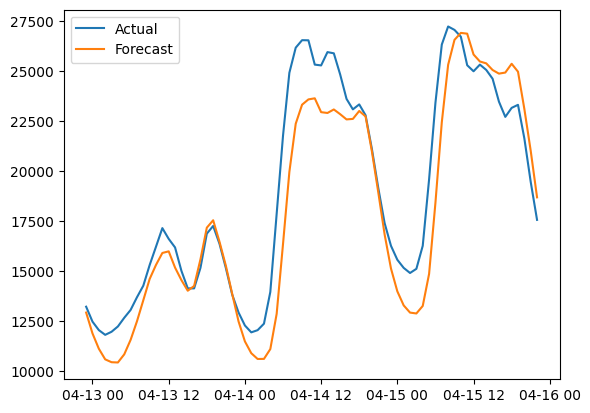

In [42]:
plt.plot(aggr_test.index, aggr_test['load'], label='Actual')
plt.plot(aggr_test.index, forecast, label = 'Forecast')
plt.legend()
plt.show()

In [43]:
rmse = np.sqrt(np.mean((aggr_test.load.values - forecast.values)**2))
mape = np.mean(np.abs((aggr_test.load.values - forecast.values) / aggr_test.load.values)) * 100
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')

RMSE: 2025.08
MAPE: 8.07%


In [29]:
gen = terna_api.get_generation_data_TERNA(source = 'All', start_extr = start_extr)
parsed_gen = terna_api.parsing_generation_data(gen)

START: 2025-01-01 - END: today for Thermal&type=Wind&type=Geothermal&type=Photovoltaic&type=Self-consumption&type=Hydro&type=Net Foreign Exchange&type=Pumping-consumption energy generation
{"result":{"message":"Operation completed for the following request: {$and:[{DATA_ORA:{$gte:\"2025-01-01\", $lte:\"2025-03-01\"}},{DATA_ORA:{$lt:\"2025-04-16\"}}], TIPO:{$in:[ \"Thermal\", \"Wind\", \"Geothermal\", \"Photovoltaic\", \"Self-consumption\", \"Hydro\", \"Net Foreign Exchange\", \"Pumping-consumption\" ]}}","status":"Completed"},"energyBalance":[{"Date":"2025-03-01 23:45:00","Energy_Balance_GWh":"3.04","Energy_Source":"Thermal"},{"Date":"2025-03-01 23:45:00","Energy_Balance_GWh":"-0.07","Energy_Source":"Pumping-consumption"},{"Date":"2025-03-01 23:45:00","Energy_Balance_GWh":"0.755","Energy_Source":"Self-consumption"},{"Date":"2025-03-01 23:45:00","Energy_Balance_GWh":"1.98","Energy_Source":"Net Foreign Exchange"},{"Date":"2025-03-01 23:45:00","Energy_Balance_GWh":"0","Energy_Source":"Pho

Date Energy_Balance_GWh         Energy_Source
0      2025-03-01 23:45:00               3.04               Thermal
1      2025-03-01 23:45:00              -0.07   Pumping-consumption
2      2025-03-01 23:45:00              0.755      Self-consumption
3      2025-03-01 23:45:00               1.98  Net Foreign Exchange
4      2025-03-01 23:45:00                  0          Photovoltaic
...                    ...                ...                   ...
34523  2025-03-02 00:00:00                  0          Photovoltaic
34524  2025-03-02 00:00:00               0.15            Geothermal
34525  2025-03-02 00:00:00               0.62                  Wind
34526  2025-03-02 00:00:00               2.71               Thermal
34527  2025-03-02 00:00:00                0.9                 Hydro

[72544 rows x 3 columns]